# Comparación de Métodos de Clustering para Coordenadas

Manuel Silva
manuel.silva@pucv.cl

In [1]:
%pip install -q numpy scikit-learn matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Importar las librerías necesarias
import numpy as np  # NumPy para operaciones numéricas y manejo de arrays
import pandas as pd  # Pandas para manipulación y análisis de datos
import matplotlib.pyplot as plt  # Matplotlib para la creación de gráficos

# Importar algoritmos y herramientas específicas de sklearn
from sklearn.cluster import DBSCAN, KMeans  # Algoritmos de clustering
from sklearn.metrics import silhouette_score, davies_bouldin_score  # Métricas para evaluar la calidad del clustering
from sklearn.model_selection import GridSearchCV  # Herramienta para optimizar parámetros de modelos


Se tienen 2 archivos con coordenadas (ambos excel)

In [3]:
# Cargar los datos de coordenadas
excel_file1 = 'Archivos_conversion/Atlas 28-01-2020_addUTMcoordinates.xlsx'  # Ruta del primer archivo de Excel
excel_file2 = 'Archivos_conversion/CDR_CHILE_2023_addUTMcoordinates.xlsx'  # Ruta del segundo archivo de Excel
df1 = pd.read_excel(excel_file1, usecols="AA")  # Cargar solo la columna AA del primer archivo
df2 = pd.read_excel(excel_file2, usecols="X")  # Cargar solo la columna X del segundo archivo

# Combinar los datos de latitud y longitud de ambos dataframes
merged_latlon = pd.concat([df1['lat_lon_pair'], df2['lat_lon_pair']])  # Concatenar los valores en una sola serie

# Limpiar datos eliminando valores nulos
merged_latlon.dropna(inplace=True)  # Eliminar filas con valores NaN directamente en la serie original


In [4]:
# Limpieza de Datos: Eliminar valores infinitos o NaN
coords_list = []  # Inicializar una lista vacía para almacenar coordenadas válidas
for point in merged_latlon:
    try:
        lat, lon = map(float, point.split(','))  # Intentar convertir cada punto a pares de floats (latitud, longitud)
        if np.isfinite(lat) and np.isfinite(lon):  # Verificar que ambos valores sean finitos
            coords_list.append([lat, lon])  # Agregar la coordenada a la lista si ambos valores son finitos
    except ValueError:
        continue  # Omitir puntos que no se puedan convertir a float

# Verificar si la lista de coordenadas está vacía
if not coords_list:
    raise ValueError("No hay suficientes datos válidos para realizar el clustering.")  # Lanzar excepción si la lista está vacía

coords_array = np.array(coords_list)  # Convertir la lista de coordenadas en un array de NumPy

# Verificación adicional para asegurarse de que no haya valores infinitos o NaN
if np.any(np.isnan(coords_array)) or np.any(np.isinf(coords_array)):
    raise ValueError("Los datos aún contienen valores NaN o infinitos.")  # Lanzar excepción si se encuentran NaN o infinitos


In [5]:
# Combinar las columnas de coordenadas de ambos dataframes en una serie única
merged_latlon = pd.concat([df1['lat_lon_pair'], df2['lat_lon_pair']])  # Concatenar las series de latitud y longitud de df1 y df2

# Limpiar la serie combinada eliminando filas con valores NaN
merged_latlon.dropna(inplace=True)  # Eliminar directamente los valores NaN en la serie original


In [6]:
# Convertir la serie en un array de NumPy adecuado y
# separar las cadenas por la coma, convertir a float y manejar posibles errores
coords_list = []  # Iniciar lista para almacenar coordenadas válidas
for point in merged_latlon:
    try:
        lat, lon = map(float, point.split(','))  # Intentar dividir cada punto en latitud y longitud y convertir a float
        coords_list.append([lat, lon])  # Añadir la pareja de coordenadas a la lista
    except ValueError:
        continue  # Omitir puntos que no se puedan convertir a float

coords_array = np.array(coords_list)  # Convertir la lista de coordenadas en un array de NumPy

# Asegurarse de que no haya datos infinitos o muy grandes
if np.isinf(coords_array).any() or np.isnan(coords_array).any():
    print("Se encontraron valores infinitos o NaN en los datos, que serán omitidos.")
    # Filtrar y eliminar filas con valores infinitos o NaN
    coords_array = coords_array[~np.isinf(coords_array).any(axis=1)]
    coords_array = coords_array[~np.isnan(coords_array).any(axis=1)]


Se encontraron valores infinitos o NaN en los datos, que serán omitidos.


## DBSCAN con búsqueda de parámetros

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import numpy as np

# Definir los rangos de parámetros para DBSCAN
eps_range = np.arange(0.1, 0.5, 0.1)  # Definir rango de valores epsilon desde 0.1 hasta 1.0 con incrementos de 0.1
min_samples_range = range(2, 100)  # Definir rango de valores mínimos de muestras desde 2 hasta 100

# Preparar los datos
X = coords_array  # Usar array de coordenadas preprocesadas como datos de entrada

# Almacenar los mejores parámetros y el mejor score
best_score = -1  # Inicializar el mejor score como -1 para asegurar la primera asignación
best_params = {}  # Inicializar diccionario para almacenar los mejores parámetros

# Evaluar todas las combinaciones de parámetros
for eps in eps_range:
    for min_samples in min_samples_range:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)  # Instanciar DBSCAN con parámetros actuales
        clusters = dbscan.fit_predict(X)  # Ajustar el modelo y predecir los clusters
        num_unique_clusters = len(set(clusters))  # Contar los clusters únicos, excluyendo ruido
        # Evaluar solo si hay más de un cluster y ninguno es ruido (etiqueta -1)
        if num_unique_clusters > 1 and -1 not in clusters:
            score = silhouette_score(X, clusters)  # Calcular el score de silueta para la configuración actual
            print(f"eps: {eps}, min_samples: {min_samples}, score: {score}, unique_clusters: {num_unique_clusters}")
            if score > best_score:
                best_score = score  # Actualizar el mejor score si el actual es mayor
                best_params = {'eps': eps, 'min_samples': min_samples, 'unique_clusters': num_unique_clusters}
        else:
            print(f"eps: {eps}, min_samples: {min_samples}, score: -1, unique_clusters: {num_unique_clusters} (Degenerate case)")

print("\nMejores parámetros para DBSCAN:", best_params)  # Imprimir los mejores parámetros encontrados
print("Mejor score de silueta para DBSCAN:", best_score)  # Imprimir el mejor score de silueta encontrado


In [12]:
# Aplicar DBSCAN para clustering
dbscan = DBSCAN(eps=0.3, min_samples=10)
labels_db = dbscan.fit_predict(X)  # Asegúrate de que X es tu conjunto de datos


## K-MEANS con búsqueda de parámetros

In [9]:
# Definir los rangos de parámetros para KMeans
n_clusters_range = range(2, 3)  # Rango de número de clusters a evaluar
init_options = ['k-means++', 'random']  # Métodos de inicialización a considerar
n_init_options = [10, 11]  # Número de inicializaciones distintas a probar

# Preparar los datos
X = coords_array  # Utilizar el array de coordenadas preprocesadas como entrada de datos

# Almacenar los mejores parámetros y el mejor score
best_score = -1  # Inicializar el mejor score como -1 para asegurar que cualquier score válido lo superará
best_params = {}  # Inicializar un diccionario para almacenar los mejores parámetros encontrados

# Evaluar todas las combinaciones de parámetros
for n_clusters in n_clusters_range:
    for init in init_options:
        for n_init in n_init_options:
            kmeans = KMeans(n_clusters=n_clusters, init=init, n_init=n_init, random_state=0)  # Instanciar KMeans con parámetros actuales
            clusters = kmeans.fit_predict(X)  # Ajustar el modelo y predecir los clusters
            num_unique_clusters = len(set(clusters))  # Contar los clusters únicos
            # Evaluar solo si hay más de un cluster y ninguno es ruido
            if num_unique_clusters > 1 and -1 not in clusters:
                score = silhouette_score(X, clusters)  # Calcular el score de silueta para la configuración actual
                print(f"n_clusters: {n_clusters}, init: {init}, n_init: {n_init}, score: {score}, unique_clusters: {num_unique_clusters}")
                if score > best_score:
                    best_score = score  # Actualizar el mejor score si el actual es mayor
                    best_params = {'n_clusters': n_clusters, 'init': init, 'n_init': n_init, 'unique_clusters': num_unique_clusters}
            else:
                print(f"n_clusters: {n_clusters}, init: {init}, n_init: {n_init}, score: -1, unique_clusters: {num_unique_clusters} (Degenerate case)")

print("\nMejores parámetros:", best_params)  # Imprimir los mejores parámetros encontrados
print("Mejor score de silueta:", best_score)  # Imprimir el mejor score de silueta encontrado


n_clusters: 2, init: k-means++, n_init: 10, score: 0.8166693106005883, unique_clusters: 2
n_clusters: 2, init: k-means++, n_init: 11, score: 0.8166693106005883, unique_clusters: 2
n_clusters: 2, init: random, n_init: 10, score: 0.8166693106005883, unique_clusters: 2
n_clusters: 2, init: random, n_init: 11, score: 0.8166693106005883, unique_clusters: 2

Mejores parámetros: {'n_clusters': 2, 'init': 'k-means++', 'n_init': 10, 'unique_clusters': 2}
Mejor score de silueta: 0.8166693106005883


## Plot resultados

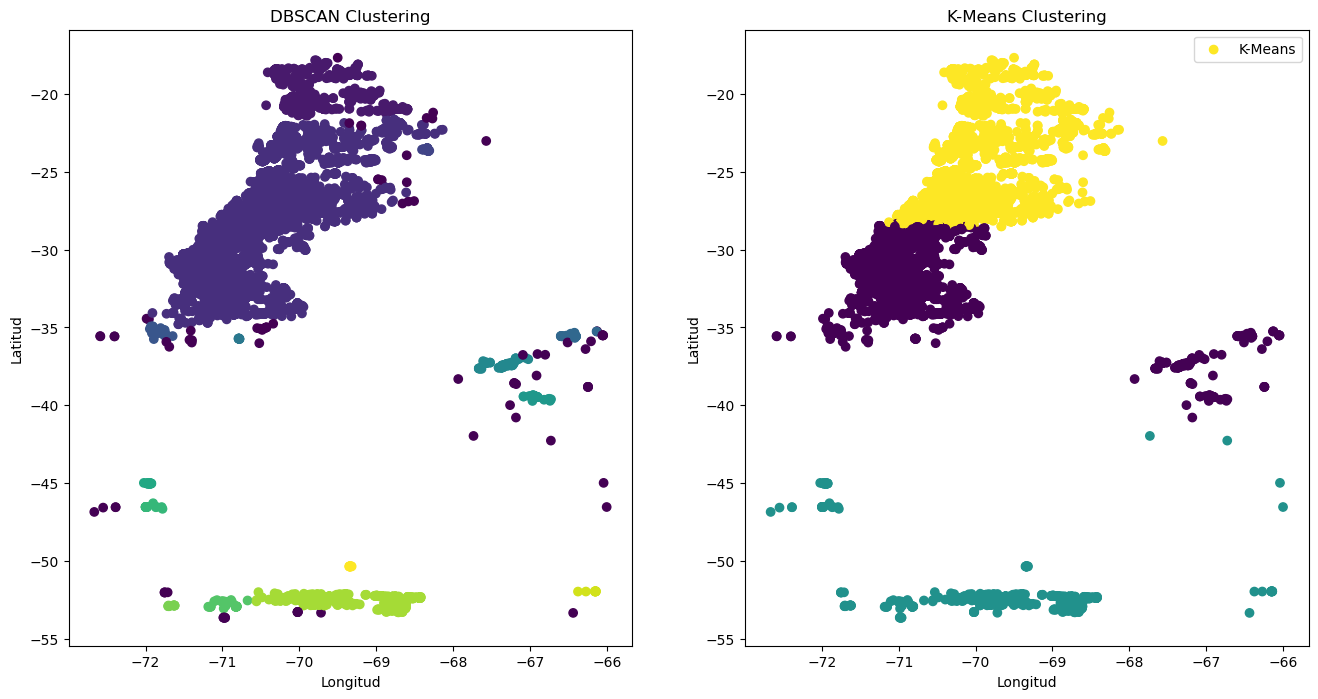

In [16]:
# Visualización de los resultados de clustering
fig, ax = plt.subplots(1, 2, figsize=(16, 8))  # Crear una figura y un arreglo de subgráficos con 2 paneles

# Dibujar los resultados del clustering de DBSCAN en el primer subgráfico
ax[0].scatter(coords_array[:, 1], coords_array[:, 0], c=labels_db, cmap='viridis', label='DBSCAN')
ax[0].set_title('DBSCAN Clustering')  # Título del primer subgráfico
ax[0].set_xlabel('Longitud')  # Etiqueta del eje X del primer subgráfico
ax[0].set_ylabel('Latitud')  # Etiqueta del eje Y del primer subgráfico

# Dibujar los resultados del clustering de K-Means en el segundo subgráfico
ax[1].scatter(coords_array[:, 1], coords_array[:, 0], c=labels_km, cmap='viridis', label='K-Means')
ax[1].set_title('K-Means Clustering')  # Título del segundo subgráfico
ax[1].set_xlabel('Longitud')  # Etiqueta del eje X del segundo subgráfico
ax[1].set_ylabel('Latitud')  # Etiqueta del eje Y del segundo subgráfico

plt.legend()  # Mostrar la leyenda que identifica cada grupo
plt.show()  # Mostrar la figura con los gráficos


Análisis de Validación de Clusters. (sacado de internet)

Después de realizar un análisis de clustering, es importante evaluar qué tan bien se han formado los clusters. Dos métricas comunes para evaluar la calidad de los clusters son el coeficiente de silueta y el coeficiente de Davies-Bouldin:

- Coeficiente de Silueta: 
-- Mide cuán similar es un objeto a su propio cluster en comparación con otros clusters. El coeficiente de silueta varía entre -1 y +1, donde un valor alto indica que el objeto está bien emparejado con su propio cluster y mal emparejado con los clusters vecinos. Un valor cercano a 0 indica que los clusters se superponen.

- Coeficiente de Davies-Bouldin: Este índice indica la relación entre la distancia media dentro del cluster y la distancia media entre clusters. Un valor más bajo indica una mejor partición de clustering, ya que los clusters están más compactos y mejor separados.

In [17]:
# Calcular métricas de evaluación para DBSCAN y K-Means
if len(set(labels_db)) > 1 and len(set(labels_km)) > 1:
    # Asegurarse de que ambos métodos tienen más de un cluster antes de calcular métricas
    silhouette_db = silhouette_score(coords_array, labels_db)  # Calcular el score de silueta para DBSCAN
    silhouette_km = silhouette_score(coords_array, labels_km)  # Calcular el score de silueta para K-Means
    davies_bouldin_db = davies_bouldin_score(coords_array, labels_db)  # Calcular el score de Davies-Bouldin para DBSCAN
    davies_bouldin_km = davies_bouldin_score(coords_array, labels_km)  # Calcular el score de Davies-Bouldin para K-Means

    # Imprimir los resultados de las métricas
    print(f"Silueta DBSCAN: {silhouette_db}")
    print(f"Silueta K-Means: {silhouette_km}")
    print(f"Davies-Bouldin DBSCAN: {davies_bouldin_db}")
    print(f"Davies-Bouldin K-Means: {davies_bouldin_km}")
else:
    # Informar si no hay suficientes clusters para calcular las métricas
    print("Se necesita más de un cluster para calcular las métricas de validación.")


Silueta DBSCAN: 0.07451597587796144
Silueta K-Means: 0.6079389578138924
Davies-Bouldin DBSCAN: 1.5855363374451905
Davies-Bouldin K-Means: 0.4419387559661136
